In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
italy_df = pd.read_excel('International_Financial_Statistics_Italy.xlsx')
usa_df = pd.read_excel('International_Financial_Statistics_USA.xlsx')

# Rename columns for consistency and clarity
italy_new_df = italy_df.loc[1:].copy()
italy_new_df.columns = ['Date', 'Industrial Production Index',
                        'Exchange Rate to USD',
                        'International Reserves Minus Gold (USD)', 'CPI Index']

usa_new_df = usa_df.loc[1:].copy()
usa_new_df.columns = ['Date', 'International Reserves Minus Gold (USD)',
                      'CPI Index']

In [3]:
# Convert the 'Date' columns to datetime format to ensure correct merging
italy_new_df['Date'] = pd.to_datetime(italy_new_df['Date'], format='%b %Y')
usa_new_df['Date'] = pd.to_datetime(usa_new_df['Date'], format='%b %Y')

# Check that the 'Date' column is in datetime format
print(italy_new_df.head())
print(usa_new_df.head())

        Date Industrial Production Index Exchange Rate to USD  \
1 1960-01-01                   31.134278           621.118012   
2 1960-02-01                    32.60265           621.118012   
3 1960-03-01                   33.712883                620.6   
4 1960-04-01                   33.891953           625.000001   
5 1960-05-01                   34.632109           625.000001   

  International Reserves Minus Gold (USD) CPI Index  
1                                  2989.5  4.143942  
2                                  2958.5  4.136754  
3                                  2923.5  4.129566  
4                                  2959.5  4.125971  
5                                  2970.5   4.13316  
        Date International Reserves Minus Gold (USD)  CPI Index
1 1960-01-01                                 21478.1  13.436946
2 1960-02-01                                 21395.7  13.482806
3 1960-03-01                                 21344.7  13.482806
4 1960-04-01                 

In [4]:
# Ensure all required columns are numeric
italy_required_columns = ['Industrial Production Index', 'Exchange Rate to USD',
                          'International Reserves Minus Gold (USD)', 'CPI Index']
italy_new_df[italy_required_columns] = italy_new_df[italy_required_columns].apply(pd.to_numeric, errors='coerce')

usa_required_columns = ['International Reserves Minus Gold (USD)', 'CPI Index']
usa_new_df[usa_required_columns] = usa_new_df[usa_required_columns].apply(pd.to_numeric, errors='coerce')

# Check if there are any missing date values
num_missing_dates_italy = italy_new_df['Date'].isna().sum()
# Boolean indexing to identify if value is missing and sum counts the number of True values
print(f"Number of missing date values in the Italy DataFrame: {num_missing_dates_italy}")
num_missing_dates_usa = usa_new_df['Date'].isna().sum()
print(f"Number of missing date values in the USA DataFrame: {num_missing_dates_usa}")


Number of missing date values in the Italy DataFrame: 0
Number of missing date values in the USA DataFrame: 0


In [5]:
# Merge the datasets on 'Date'
merged_df = pd.merge(italy_new_df, usa_new_df, on='Date', how='outer',
                     suffixes=('_Italy', '_USA'))

# Check that the required columns in merged df are numeric
numeric_columns = merged_df.select_dtypes(include='number').columns
print(numeric_columns)

Index(['Industrial Production Index', 'Exchange Rate to USD',
       'International Reserves Minus Gold (USD)_Italy', 'CPI Index_Italy',
       'International Reserves Minus Gold (USD)_USA', 'CPI Index_USA'],
      dtype='object')


Number of outliers in 'Industrial Production Index': 0


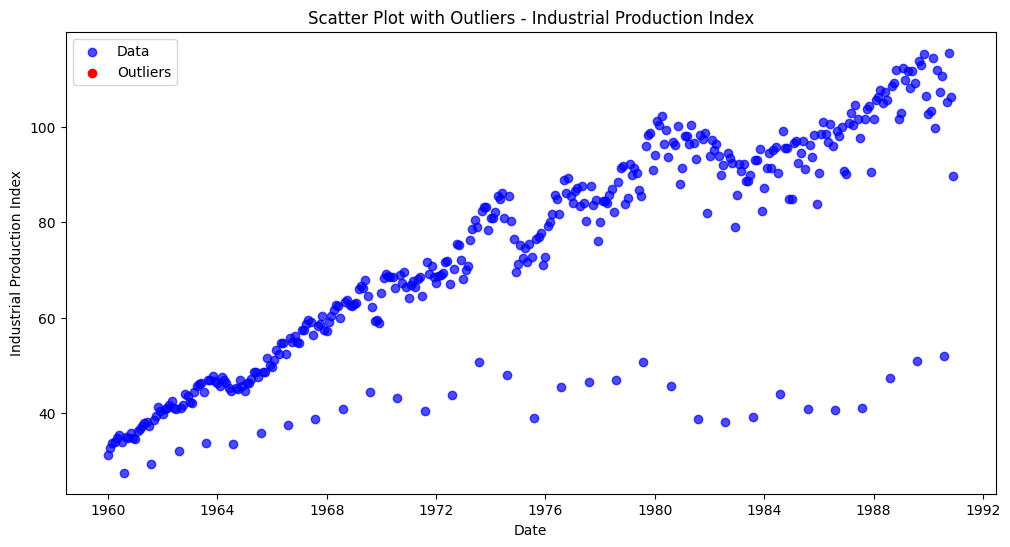

Number of outliers in 'Exchange Rate to USD': 0


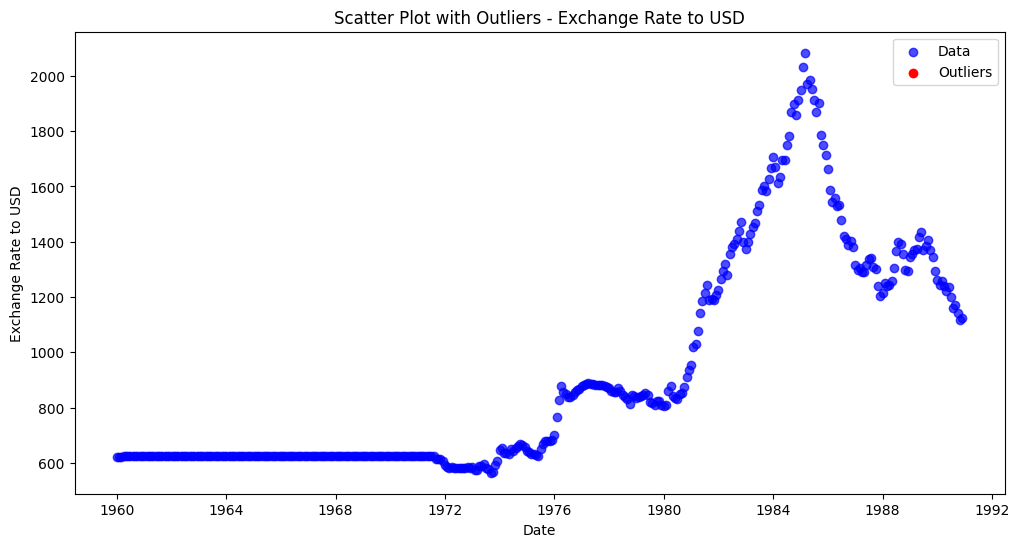

Number of outliers in 'International Reserves Minus Gold (USD)_Italy': 0


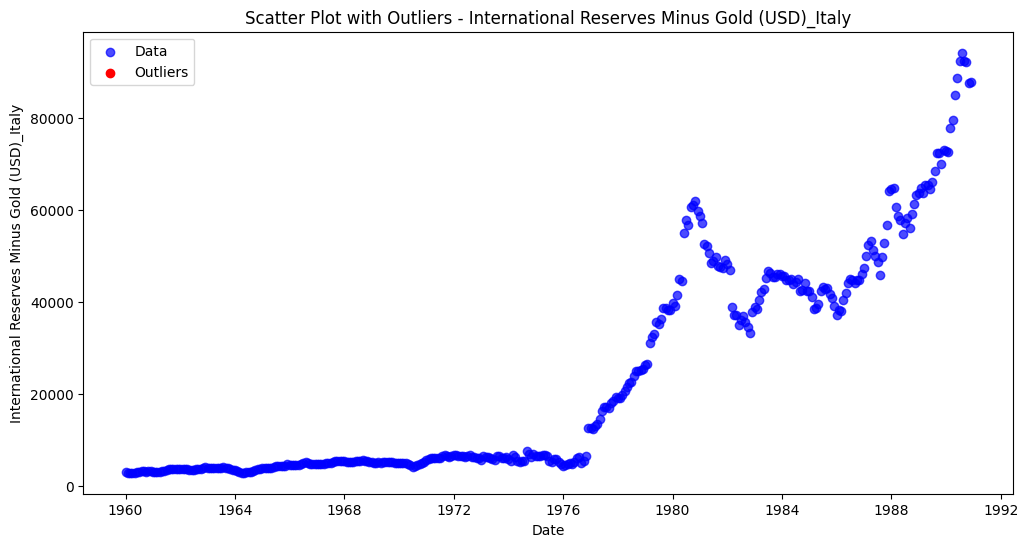

Number of outliers in 'CPI Index_Italy': 0


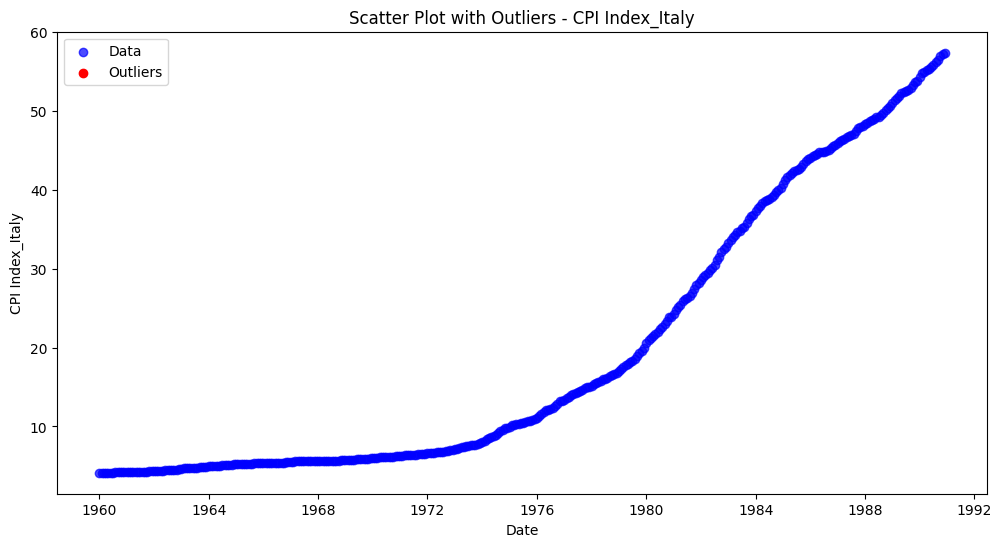

Number of outliers in 'International Reserves Minus Gold (USD)_USA': 18


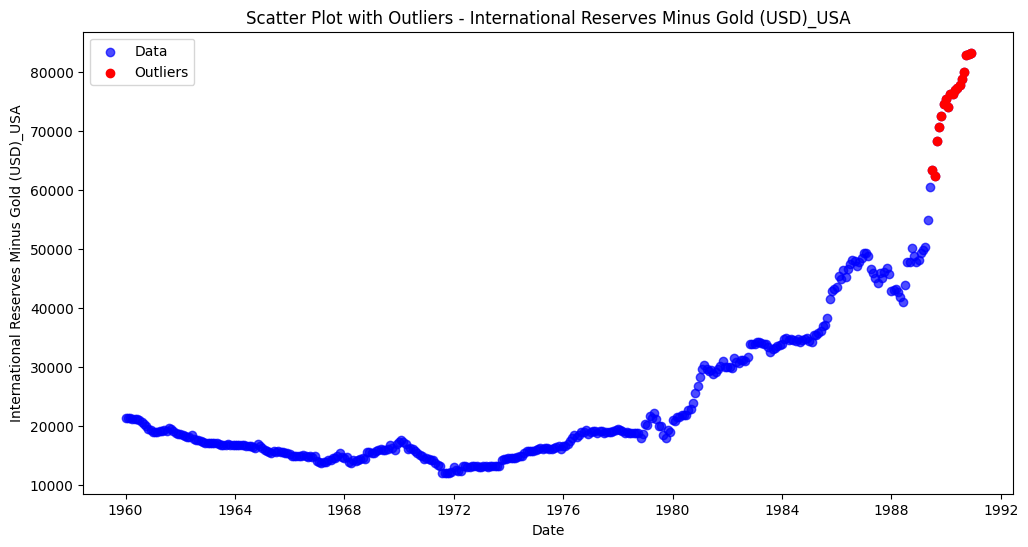

Number of outliers in 'CPI Index_USA': 0


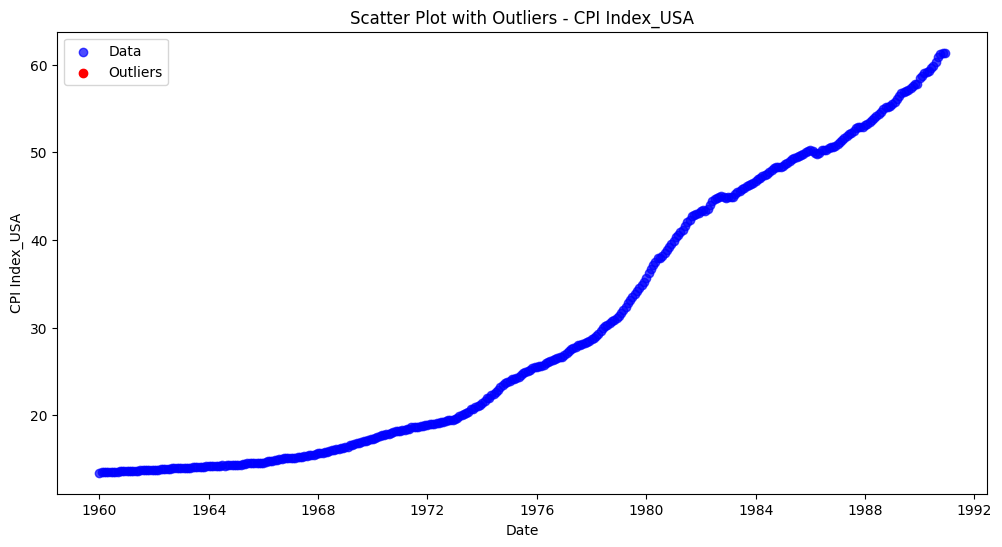

In [6]:
# Identify outliers from all numeric columns using the IQR method

# Define the threshold for considering a point as an outlier
outlier_threshold = 1.5

# Create a for loop to conduct IQR testing for all numeric columns
for column in numeric_columns:
    # Calculate the IQR for the current column
    Q1 = merged_df[column].quantile(0.25)
    Q3 = merged_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers based on the IQR method
    outliers = (
            (merged_df[column] < Q1 - outlier_threshold * IQR) |
            (merged_df[column] > Q3 + outlier_threshold * IQR)
    )

    # Count outliers
    number_of_outliers = outliers.sum()
    print(f"Number of outliers in '{column}': {number_of_outliers}")

    # Plot scatter plot highlighting outliers for the current column
    plt.figure(figsize=(12, 6))
    plt.scatter(merged_df['Date'], merged_df[column], label='Data', color='blue',
                alpha=0.7)
    plt.scatter(merged_df.loc[outliers, 'Date'], merged_df.loc[outliers, column],
                label='Outliers', color='red')
    plt.title(f'Scatter Plot with Outliers - {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Not removing the 18 outliers in International Reserves Minus Gold (USD)_Italy
filtered_df = merged_df.copy()

In [7]:
# Interpolate missing data in numeric columns
filtered_df[numeric_columns] = (filtered_df[numeric_columns].interpolate(method='linear'))

# Check there are no NaN values in the dataset
print(filtered_df.isnull().sum())

Date                                             0
Industrial Production Index                      0
Exchange Rate to USD                             0
International Reserves Minus Gold (USD)_Italy    0
CPI Index_Italy                                  0
International Reserves Minus Gold (USD)_USA      0
CPI Index_USA                                    0
dtype: int64


In [8]:
# Now, define variables

# Calculate the monthly growth in the nominal exchange rate for Italy
filtered_df['Italy Monthly Growth in Nominal Exchange Rate'] = filtered_df['Exchange Rate to USD'].pct_change() * 100

# Calculate the Real Exchange Rate for Italy using CPI as proxies for price levels
# Real ER = Nominal ER per USD * (CPI_USA / CPI_Italy)
filtered_df['Italy Real Exchange Rate'] = ((filtered_df['Exchange Rate to USD']
                                            * filtered_df['CPI Index_USA']) /
                                           filtered_df['CPI Index_Italy'])

# Calculate the monthly growth in the Real Exchange Rate for Italy
filtered_df['Italy Monthly Growth in Real Exchange Rate'] = filtered_df['Italy Real Exchange Rate'].pct_change() * 100

# Calculate the monthly inflation rate for Italy
filtered_df['Italy Monthly Inflation Rate'] = filtered_df['CPI Index_Italy'].pct_change() * 100

# Calculate the monthly growth in industrial production for Italy
filtered_df['Italy Monthly Growth in Industrial Production'] = (
        filtered_df['Industrial Production Index'].pct_change() * 100)

# Calculate the growth in industrial production versus 12 months ago for Italy
filtered_df['Italy Growth in Industrial Production vs 12 Months Ago'] = (
        filtered_df['Industrial Production Index'].pct_change(periods=12) * 100)

# Calculate an index of the value of international reserves for Italy

# Set the base year to be Jan 1960
base_italy_reserves = filtered_df.iloc[0]['International Reserves Minus Gold (USD)_Italy']

# Calculate the index for the other values of international reserves for Italy
filtered_df['Italy Index of International Reserves'] = (filtered_df['International Reserves Minus Gold (USD)_Italy']
                                                        / base_italy_reserves) * 100

# Calculate the monthly inflation rate for USA
filtered_df['USA Monthly Inflation Rate'] = filtered_df['CPI Index_USA'].pct_change() * 100

# Calculate an index of the value of international reserves for USA

# Set the base year to be Jan 1960
base_usa_reserves = filtered_df.iloc[0]['International Reserves Minus Gold (USD)_USA']

# Calculate the index for the other values of international reserves for USA
filtered_df['USA Index of International Reserves'] = (filtered_df['International Reserves Minus Gold (USD)_USA']
                                                      / base_usa_reserves) * 100


Number of outliers in 'Italy Monthly Growth in Nominal Exchange Rate': 89


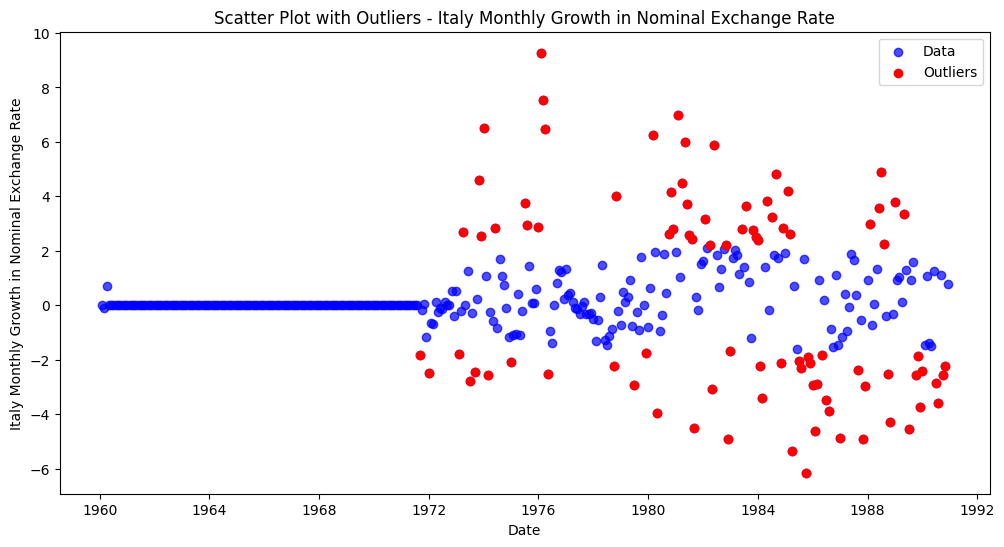

Number of outliers in 'Italy Real Exchange Rate': 8


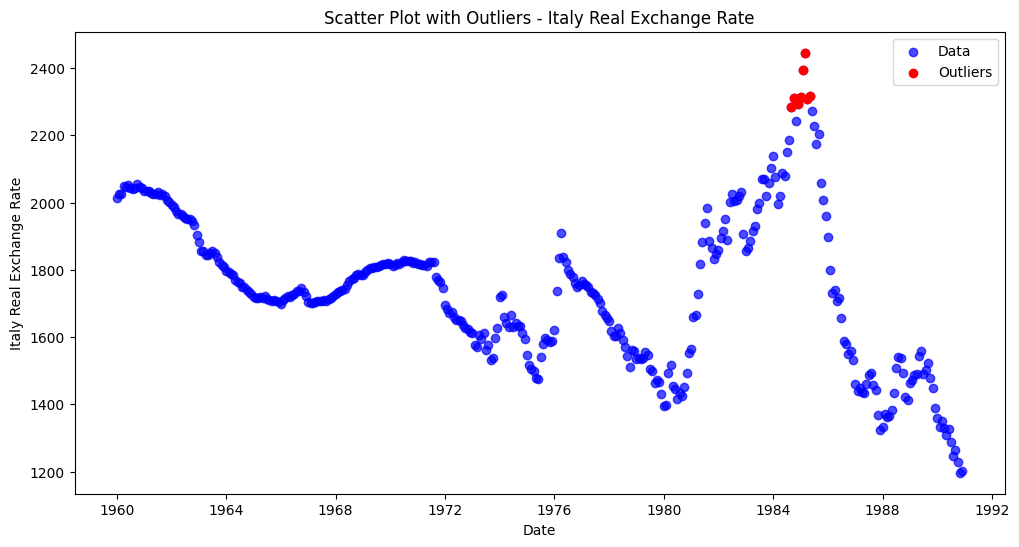

Number of outliers in 'Italy Monthly Growth in Real Exchange Rate': 61


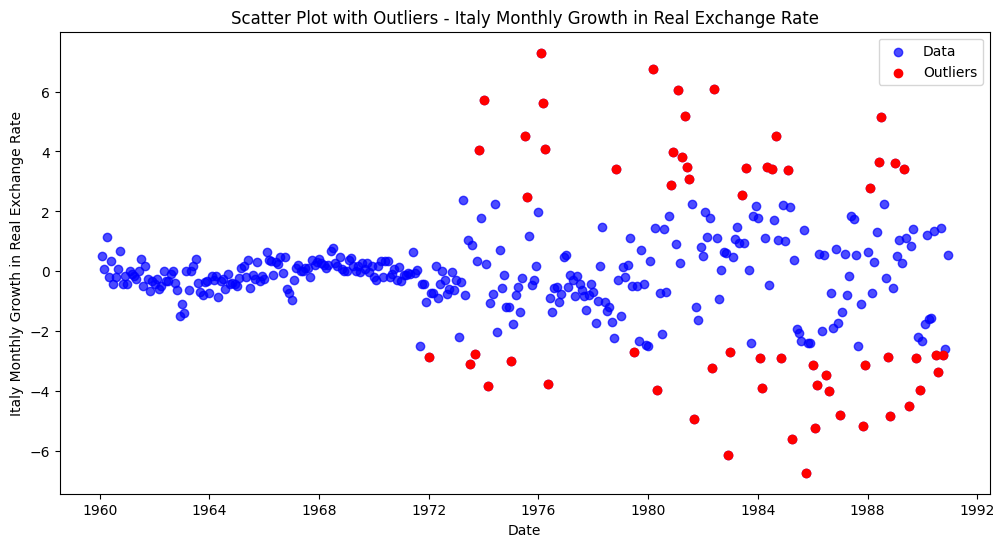

Number of outliers in 'Italy Monthly Inflation Rate': 9


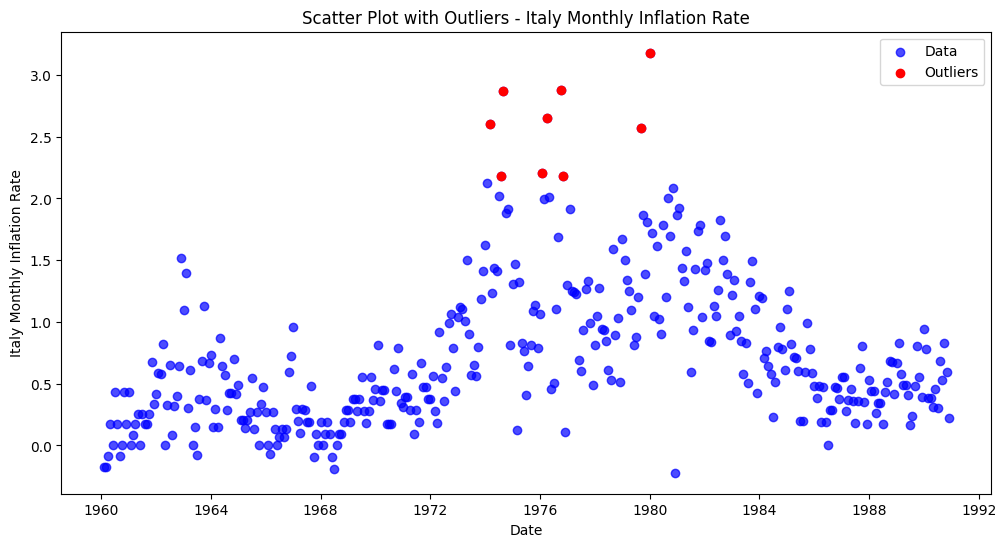

Number of outliers in 'Italy Monthly Growth in Industrial Production': 70


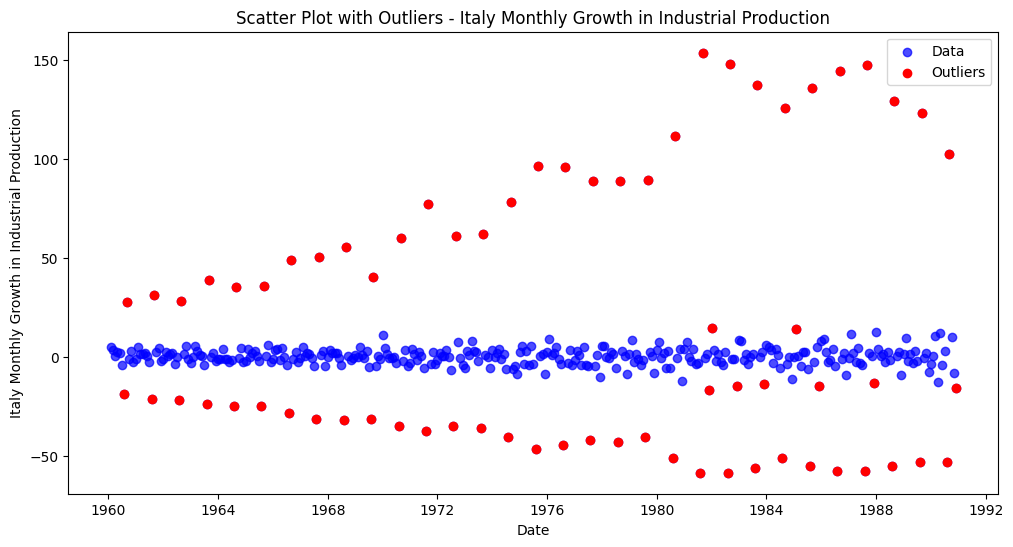

Number of outliers in 'Italy Growth in Industrial Production vs 12 Months Ago': 4


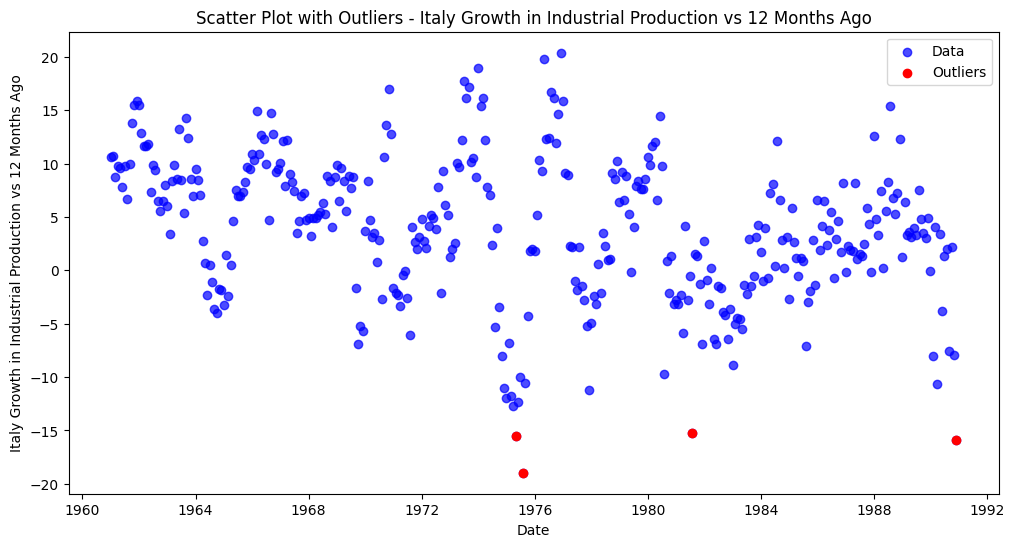

Number of outliers in 'Italy Index of International Reserves': 0


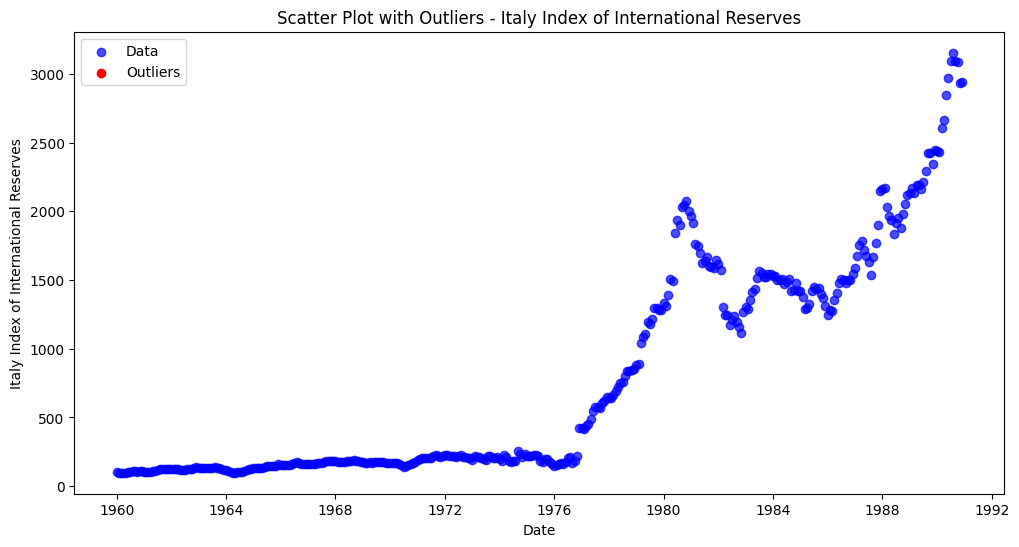

Number of outliers in 'USA Monthly Inflation Rate': 14


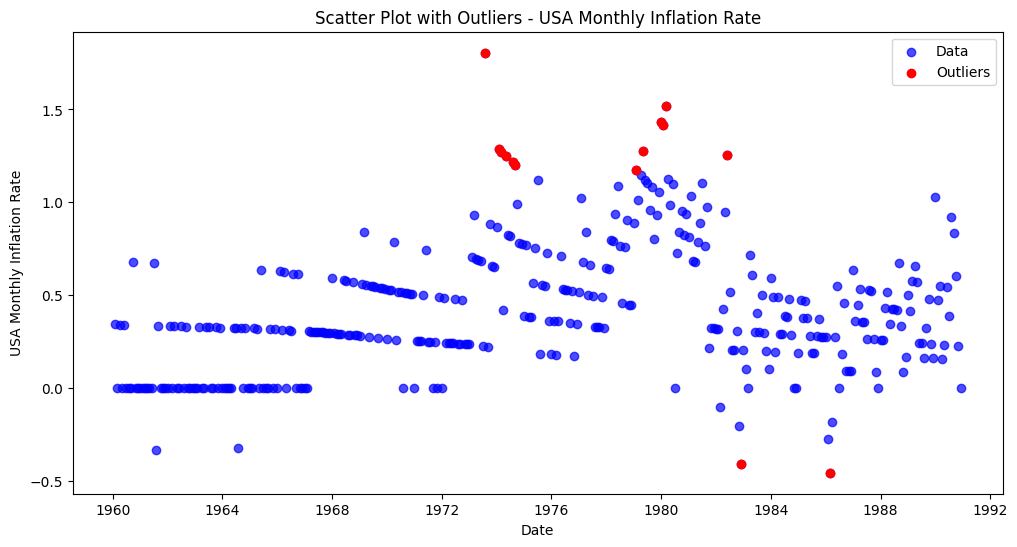

Number of outliers in 'USA Index of International Reserves': 18


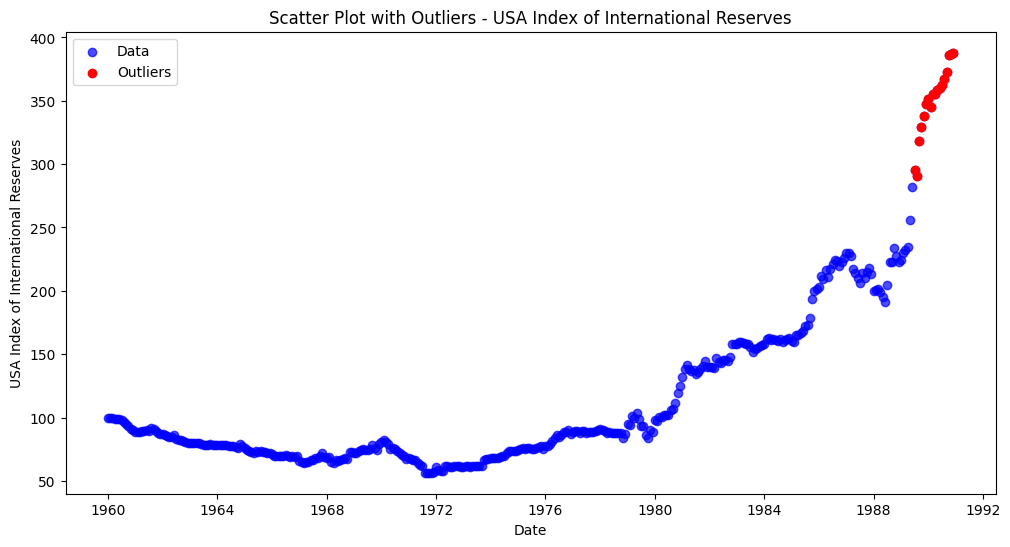

In [9]:
# Check for outliers in new variables
# Create a list of the new variables
new_columns = ['Italy Monthly Growth in Nominal Exchange Rate', 'Italy Real Exchange Rate',
               'Italy Monthly Growth in Real Exchange Rate', 'Italy Monthly Inflation Rate',
               'Italy Monthly Growth in Industrial Production',
               'Italy Growth in Industrial Production vs 12 Months Ago', 'Italy Index of International Reserves',
               'USA Monthly Inflation Rate', 'USA Index of International Reserves']

# Create a for loop to conduct IQR testing for all new columns
for column in new_columns:
    # Calculate the IQR for the current column
    Q1 = filtered_df[column].quantile(0.25)
    Q3 = filtered_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identify and filter outliers based on the IQR method
    outliers = (
            (filtered_df[column] < Q1 - outlier_threshold * IQR) |
            (filtered_df[column] > Q3 + outlier_threshold * IQR)
    )

    # Count outliers
    number_of_outliers = outliers.sum()
    print(f"Number of outliers in '{column}': {number_of_outliers}")

    # Plot scatter plot highlighting outliers for the current column
    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_df['Date'], filtered_df[column], label='Data',
                color='blue', alpha=0.7)
    plt.scatter(filtered_df.loc[outliers, 'Date'],
                filtered_df.loc[outliers, column], label='Outliers', color='red')
    plt.title(f'Scatter Plot with Outliers - {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()

# Not removing any outliers
filtered_again_df = filtered_df.copy()

In [10]:
# Interpolate missing values in new variables
filtered_again_df[new_columns] = (filtered_again_df[new_columns].interpolate(method='linear'))

# Check there are no NaN values in the dataset
print(filtered_again_df.isnull().sum())

Date                                                       0
Industrial Production Index                                0
Exchange Rate to USD                                       0
International Reserves Minus Gold (USD)_Italy              0
CPI Index_Italy                                            0
International Reserves Minus Gold (USD)_USA                0
CPI Index_USA                                              0
Italy Monthly Growth in Nominal Exchange Rate              1
Italy Real Exchange Rate                                   0
Italy Monthly Growth in Real Exchange Rate                 1
Italy Monthly Inflation Rate                               1
Italy Monthly Growth in Industrial Production              1
Italy Growth in Industrial Production vs 12 Months Ago    12
Italy Index of International Reserves                      0
USA Monthly Inflation Rate                                 1
USA Index of International Reserves                        0
dtype: int64


In [11]:
# Print the full merged dataset

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the table
print(filtered_again_df)

          Date  Industrial Production Index  Exchange Rate to USD  \
0   1960-01-01                    31.134278            621.118012   
1   1960-02-01                    32.602650            621.118012   
2   1960-03-01                    33.712883            620.600000   
3   1960-04-01                    33.891953            625.000001   
4   1960-05-01                    34.632109            625.000001   
5   1960-06-01                    35.372264            625.000001   
6   1960-07-01                    33.891953            625.000001   
7   1960-08-01                    27.445439            625.000001   
8   1960-09-01                    35.002186            625.000001   
9   1960-10-01                    34.632109            625.000001   
10  1960-11-01                    35.730404            625.000001   
11  1960-12-01                    34.811178            625.000001   
12  1961-01-01                    34.441101            625.000001   
13  1961-02-01                    

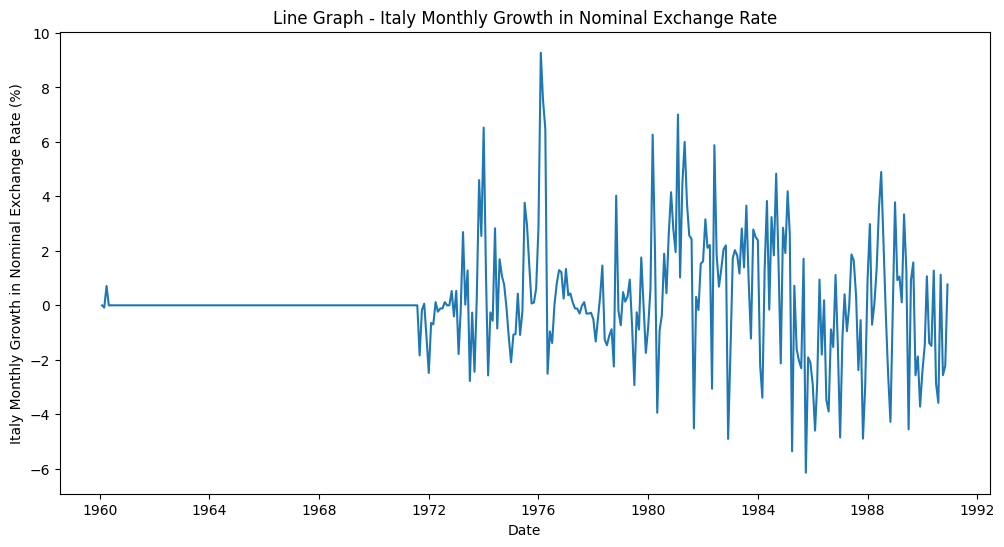

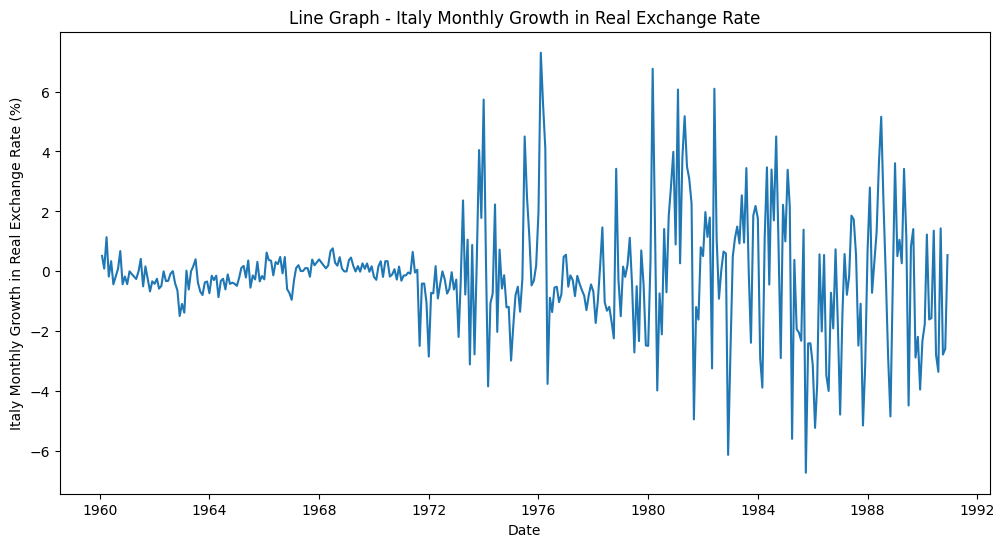

In [12]:
# To answer 5.1
# Plot line graph relating date to monthly growth in nominal ER for Italy
plt.figure(figsize=(12, 6))
plt.plot(filtered_again_df['Date'], filtered_again_df['Italy Monthly Growth in Nominal Exchange Rate'])
plt.title('Line Graph - Italy Monthly Growth in Nominal Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Growth in Nominal Exchange Rate (%)')
plt.show()

# Plot line graph relating date to monthly growth in real ER for Italy
plt.figure(figsize=(12, 6))
plt.plot(filtered_again_df['Date'], filtered_again_df['Italy Monthly Growth in Real Exchange Rate'])
plt.title('Line Graph - Italy Monthly Growth in Real Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Growth in Real Exchange Rate (%)')
plt.show()

In [13]:
# To answer 5.2
# Check the number of rows in the cleaned dataset
pd.set_option('display.max_rows', None)
print(filtered_again_df)

          Date  Industrial Production Index  Exchange Rate to USD  \
0   1960-01-01                    31.134278            621.118012   
1   1960-02-01                    32.602650            621.118012   
2   1960-03-01                    33.712883            620.600000   
3   1960-04-01                    33.891953            625.000001   
4   1960-05-01                    34.632109            625.000001   
5   1960-06-01                    35.372264            625.000001   
6   1960-07-01                    33.891953            625.000001   
7   1960-08-01                    27.445439            625.000001   
8   1960-09-01                    35.002186            625.000001   
9   1960-10-01                    34.632109            625.000001   
10  1960-11-01                    35.730404            625.000001   
11  1960-12-01                    34.811178            625.000001   
12  1961-01-01                    34.441101            625.000001   
13  1961-02-01                    

In [14]:
# To answer 5.3
# Split the filtered_again_df into two subsets - before and after Italy left BW
before_aug_1971_df = filtered_again_df[filtered_again_df['Date'] < '1971-08-15']
after_aug_1971_df = filtered_again_df[filtered_again_df['Date'] >= '1971-08-15']

# Display the first few rows of each subset for verification
print("Subset before August 1971:")
print(before_aug_1971_df.head())

print("Subset after August 1971:")
print(after_aug_1971_df.head())

Subset before August 1971:
        Date  Industrial Production Index  Exchange Rate to USD  \
0 1960-01-01                    31.134278            621.118012   
1 1960-02-01                    32.602650            621.118012   
2 1960-03-01                    33.712883            620.600000   
3 1960-04-01                    33.891953            625.000001   
4 1960-05-01                    34.632109            625.000001   

   International Reserves Minus Gold (USD)_Italy  CPI Index_Italy  \
0                                         2989.5         4.143942   
1                                         2958.5         4.136754   
2                                         2923.5         4.129566   
3                                         2959.5         4.125971   
4                                         2970.5         4.133160   

   International Reserves Minus Gold (USD)_USA  CPI Index_USA  \
0                                      21478.1      13.436946   
1                        

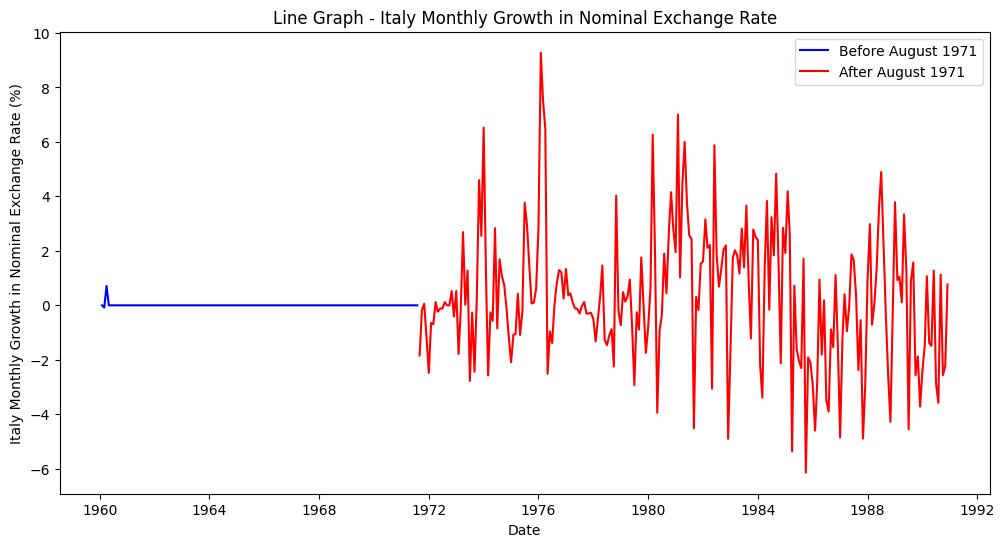

In [15]:
# Plot line graph relating date to monthly growth in nominal ER for Italy
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Monthly Growth in Nominal Exchange Rate'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Monthly Growth in Nominal Exchange Rate'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Monthly Growth in Nominal Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Growth in Nominal Exchange Rate (%)')
plt.legend()  # Display legend to differentiate lines
plt.show()

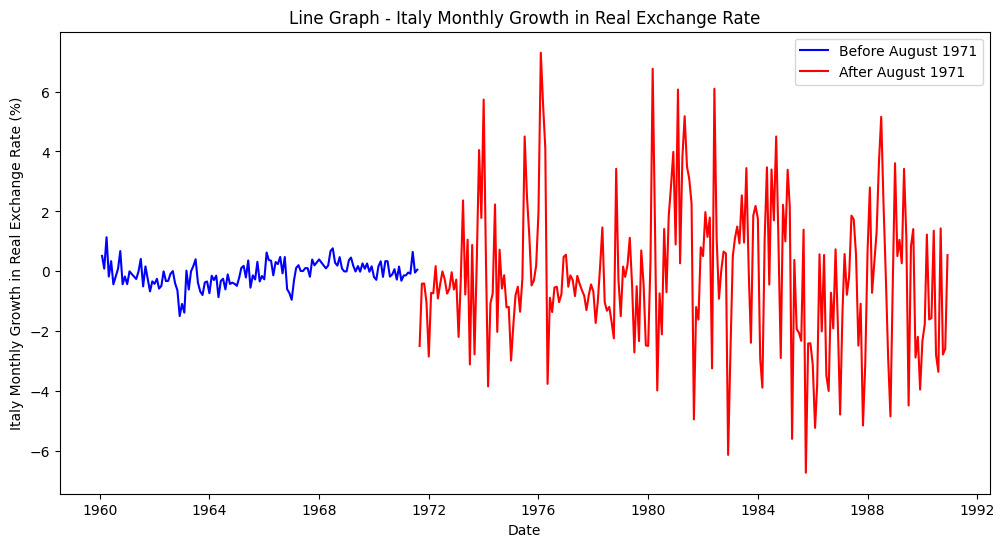

In [16]:
# Plot line graph relating date to monthly growth in real ER for Italy
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Monthly Growth in Real Exchange Rate'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Monthly Growth in Real Exchange Rate'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Monthly Growth in Real Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Growth in Real Exchange Rate (%)')
plt.legend()  # Display legend to differentiate lines
plt.show()

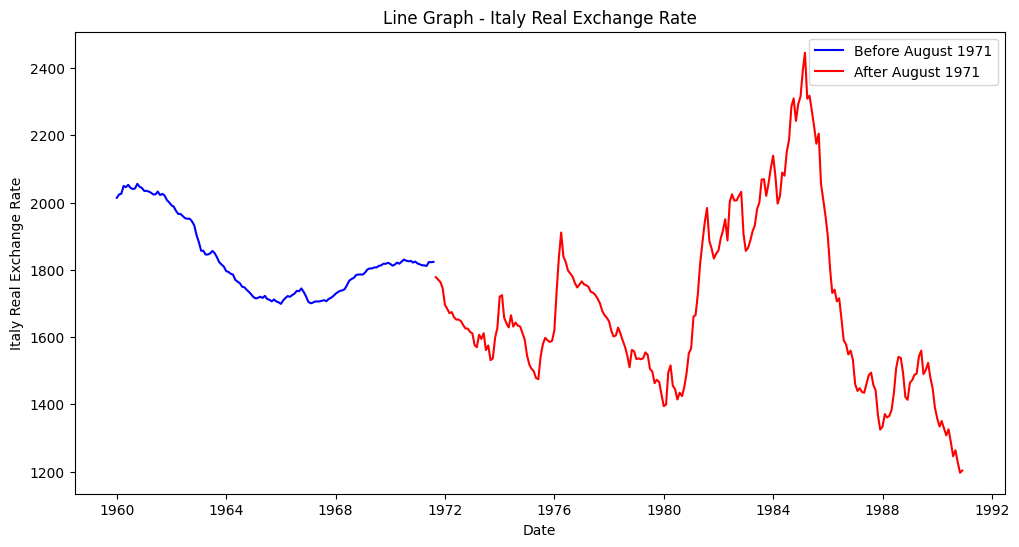

In [17]:
# Plot line graph relating date to real ER for Italy
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Real Exchange Rate'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Real Exchange Rate'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Real Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Italy Real Exchange Rate')
plt.legend()  # Display legend to differentiate lines
plt.show()

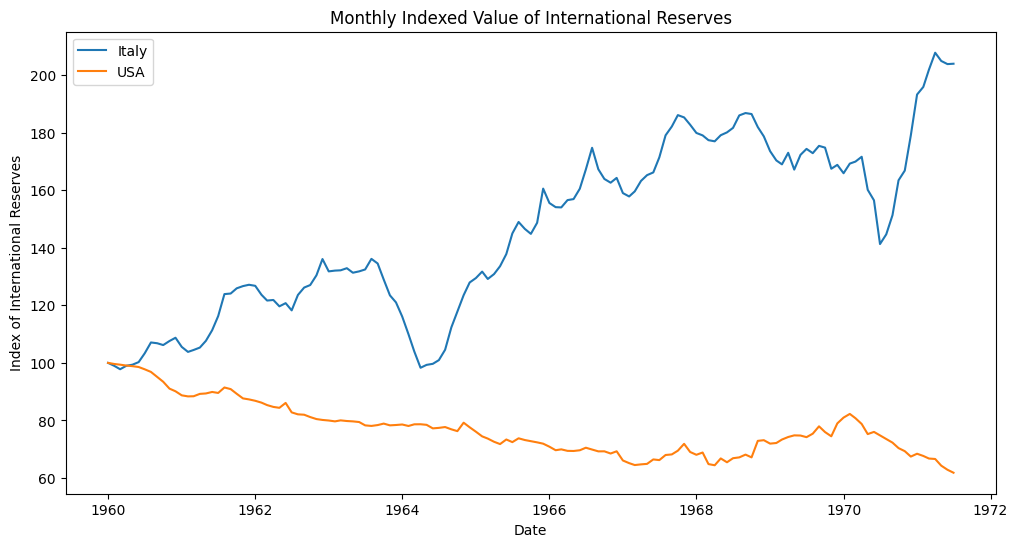

In [18]:
# USA left the BW in August 1971
before_USA_left_BW_df = filtered_again_df[filtered_again_df['Date'] < '1971-08-01']

# Plot line graph relating date to monthly indexed value of international reserves for Italy and USA
plt.figure(figsize=(12, 6))
plt.plot(before_USA_left_BW_df['Date'], before_USA_left_BW_df['Italy Index of International Reserves'],
         label='Italy')
plt.plot(before_USA_left_BW_df['Date'], before_USA_left_BW_df['USA Index of International Reserves'],
         label='USA')
plt.title('Monthly Indexed Value of International Reserves')
plt.xlabel('Date')
plt.ylabel('Index of International Reserves')
plt.legend()  # Display legend to differentiate lines
plt.show()

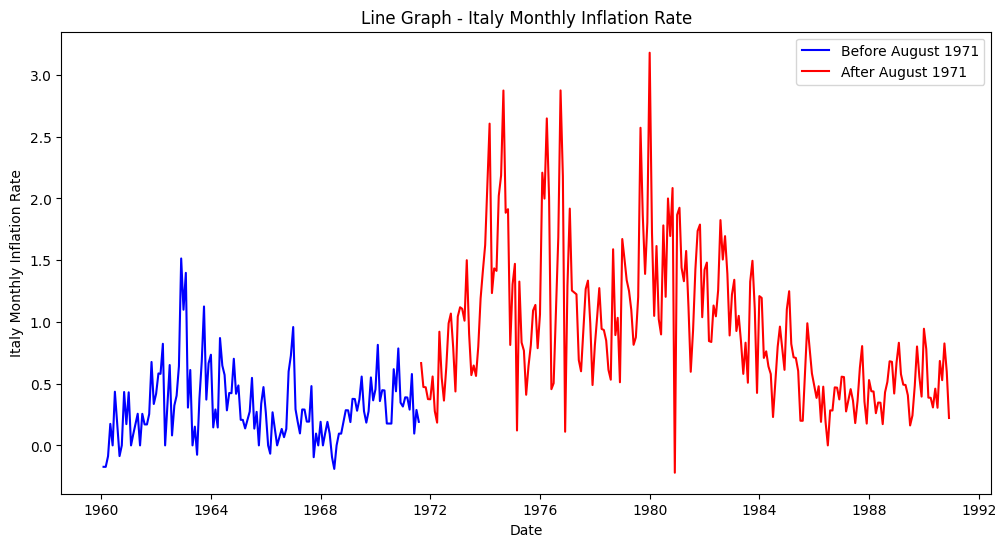

In [19]:
# Plot line graph relating date to monthly inflation
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Monthly Inflation Rate'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Monthly Inflation Rate'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Monthly Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Inflation Rate')
plt.legend()  # Display legend to differentiate lines
plt.show()

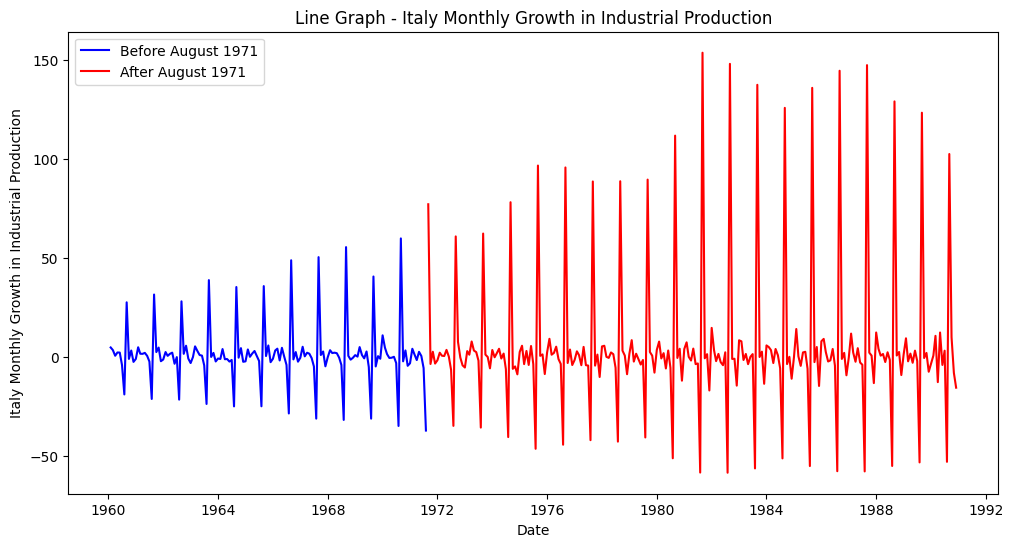

In [20]:
# Plot line graph relating date to monthly growth in industrial production
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Monthly Growth in Industrial Production'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Monthly Growth in Industrial Production'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Monthly Growth in Industrial Production')
plt.xlabel('Date')
plt.ylabel('Italy Monthly Growth in Industrial Production')
plt.legend()  # Display legend to differentiate lines
plt.show()

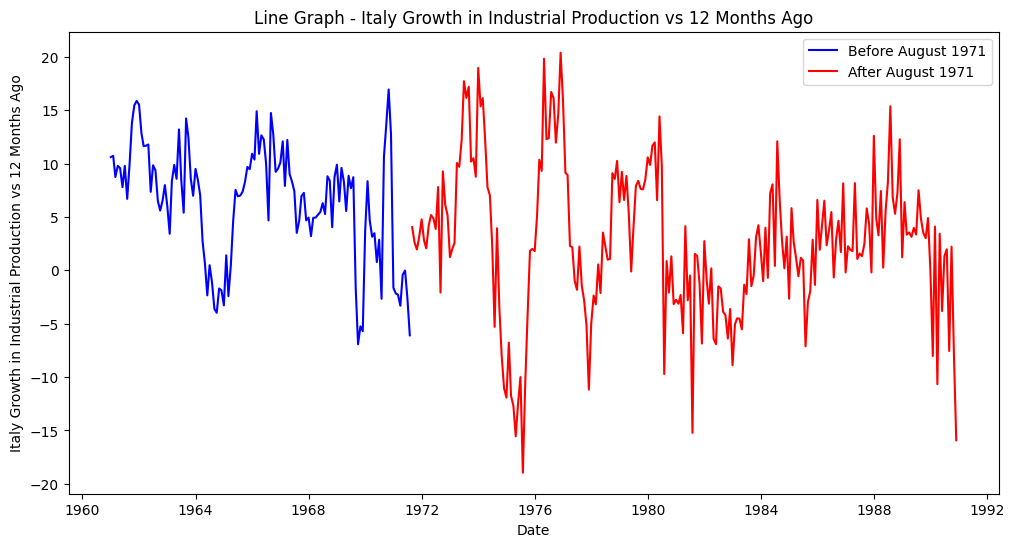

In [21]:
# Plot a time series graph of the growth in industrial production versus 12 months ago.
plt.figure(figsize=(12, 6))

# Plot before August 1971 datapoints
plt.plot(before_aug_1971_df['Date'], before_aug_1971_df['Italy Growth in Industrial Production vs 12 Months Ago'],
         label='Before August 1971', color='blue')

# Plot after August 1971 datapoints
plt.plot(after_aug_1971_df['Date'], after_aug_1971_df['Italy Growth in Industrial Production vs 12 Months Ago'],
         label='After August 1971', color='red')

plt.title('Line Graph - Italy Growth in Industrial Production vs 12 Months Ago')
plt.xlabel('Date')
plt.ylabel('Italy Growth in Industrial Production vs 12 Months Ago')
plt.legend()  # Display legend to differentiate lines
plt.show()

In [22]:
# Split the filtered_again_df into two subsets - before and after BW based on dates given in 5.3.3
before_BW_df = filtered_again_df[filtered_again_df['Date'] < '1971-07-01']
after_BW_df = filtered_again_df[filtered_again_df['Date'] >= '1973-01-01']
before_BW_df = before_BW_df.copy()
after_BW_df = after_BW_df.copy()

# Calculate difference in inflation rate between Italy and USA before BW
before_BW_df['Difference in Inflation Rate'] = (
        before_BW_df['Italy Monthly Inflation Rate'] - before_BW_df['USA Monthly Inflation Rate'])

# Calculate difference in inflation rate between Italy and USA after BW
after_BW_df['Difference in Inflation Rate'] = (
        after_BW_df['Italy Monthly Inflation Rate'] - after_BW_df['USA Monthly Inflation Rate'])

# Calculate standard deviation for each variable before and after Bretton Woods
variables = ['Italy Monthly Growth in Nominal Exchange Rate',
             'Italy Monthly Growth in Real Exchange Rate',
             'Italy Monthly Inflation Rate',
             'Difference in Inflation Rate',
             'Italy Growth in Industrial Production vs 12 Months Ago']

std_dev_before_BW = before_BW_df[variables].std()
std_dev_after_BW = after_BW_df[variables].std()

# Create a table of the standard deviation for each variable
std_dev_table = pd.DataFrame({
    'Variable': variables,
    'Standard Deviation Before BW': std_dev_before_BW.values,
    'Standard Deviation After BW': std_dev_after_BW.values,
    'Ratio (Before/After BW)': std_dev_before_BW / std_dev_after_BW
})

# To display the whole table, we need to convert the Dataframe to a string with fixed column widths
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
print(std_dev_table.to_string(index=False))

                                              Variable  Standard Deviation Before BW  Standard Deviation After BW  Ratio (Before/After BW)
         Italy Monthly Growth in Nominal Exchange Rate                      0.061043                     2.516835                 0.024254
            Italy Monthly Growth in Real Exchange Rate                      0.410608                     2.472205                 0.166090
                          Italy Monthly Inflation Rate                      0.291904                     0.601257                 0.485489
                          Difference in Inflation Rate                      0.402252                     0.559186                 0.719354
Italy Growth in Industrial Production vs 12 Months Ago                      5.216973                     7.209651                 0.723610
